# Gaussian mixture model estimation with the EM algorithm


In [2]:
import numpy as np
import scipy as sp
from scipy.stats import norm
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

from utils.gmm_tools import plot_GMM, plot_data, generate_Bayes_adventures_data

np.random.seed(0)

### Sample data points

(500, 2)


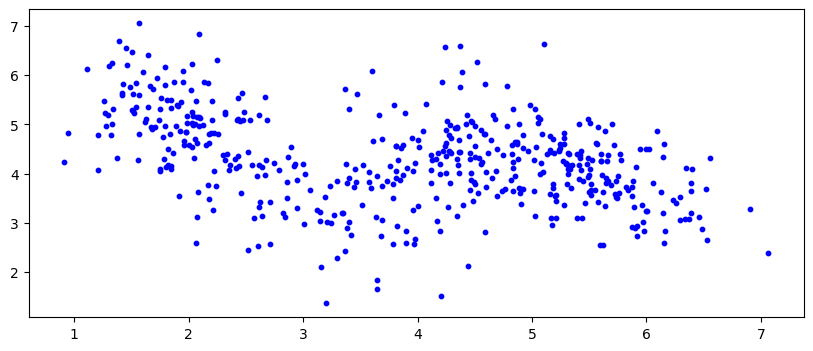

In [3]:
N = 500 # number of samples (number of stones)
D = 2 # number of dimensions (x and y coordinates)

gen = generate_Bayes_adventures_data(N, D)
x = gen[-1]

plot_data(x)
print(x.shape)

# Derivation of the equations

## Generative model

The first conceptual step of GMM is the definition of a generative model, that is, the data of a joint probability law over $X$ and $Y$.

Let a set of **observed random variables** denoted by $ \mathbf{x} = \{\mathbf{x}_n \in \mathbb{R}^2\}_{n=1}^N$, where $\mathbf{x}_n$ corresponds to the 2D position of the $n$-th stone.

These observations are generated from a set of **latent unobserved random variables** denoted by $ \mathbf{z} = \{z_n \in \{1,...,K\} \}_{n=1}^N$, where $z_n$ denotes the identity of the student (among $K=3$ students) who threw the $n$-th stone.

The relationships between the latent and observed variables are defined by their **joint distribution**, also called **complete-data likelihood**:

$$ 
\begin{aligned}
p(\mathbf{x}, \mathbf{z}; \theta) &= \prod_{n=1}^N p(\mathbf{x}_n | {z}_n; \theta) p({z}_n; \theta)  \\
&= \prod_{n=1}^N \prod_{k=1}^K \left( p(\mathbf{x}_n | {z}_n=k; \theta) p({z}_n=k; \theta) \right)^{\mathbb{1}\{z_n = k\}},
\end{aligned}
$$

where $\mathbb{1}\{z_n = k\} = \begin{cases}1 & \text{if } z_n = k \\ 0 & \text{otherwise}\end{cases}$.


The **prior** over the latent variables follows a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution):
$$ p({z}_n=k; \theta) = \pi_k, \qquad k \in \{1,...,K\}, \qquad \text{with }\, \pi_k > 0\, \text{ and }\, \sum_{k=1}^K = 1. $$

The **likelihood** is [Gaussian](https://en.wikipedia.org/wiki/Multivariate_normal_distribution):

$$ p(\mathbf{x}_n | z_n=k; \theta) = \mathcal{N}(\mathbf{x}_n; \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k),$$

with $\mathcal{N}(\mathbf{x}; \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \displaystyle \frac{1}{\sqrt{\det(2\pi \boldsymbol\Sigma)}} \exp\left(-\frac 1 2 ({\mathbf x}-{\boldsymbol\mu})^\mathrm{T}{\boldsymbol\Sigma}^{-1}({\mathbf x}-{\boldsymbol\mu})\right).$

The set of **unknown deterministic model parameters** is defined by:

$$ \theta = \{\pi_k, \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k\}_{k=1}^K. $$

The **complete-data log-likelihood** is therefore given by:
$$ \ln p(\mathbf{x}, \mathbf{z}; \theta) =  \sum_{n=1}^N \sum_{k=1}^K \mathbb{1}\{z_n = k\} \left(\ln \pi_k + \ln \mathcal{N}(\mathbf{x}_n; \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k) \right). $$

## Posterior inference

it is actually possible to give the expression of the responsabilities $ r_{n,k} \triangleq p(z_n = k | \mathbf{x}_n; \theta)$. This is what makes possible the use of the EM algotirithm. We would otherwise use other tools like variational inference.

Let Bayes' theorem: 
$$
p(z_n = k | \mathbf{x}_n; \theta) = \frac{p(z_n = k, \mathbf{x}_n; \theta)}{p(\mathbf{x}_n; \theta)} = \frac{p(\mathbf{x}_n | z_n = k; \theta) p(z_n = k; \theta)}{p(\mathbf{x}_n; \theta)}.
$$

Given the expressions above, it yields:
$$
p(z_n = k | \mathbf{x}_n; \theta) = \frac{\pi_k \mathcal{N}(\mathbf{x}_n;\mu_k, \mathbf{\Sigma}_k)}{\sum_{i = 1}^K \pi_k \mathcal{N}(\mathbf{x}_n;\mu_k, \mathbf{\Sigma}_k)} = r_{n,k}.
$$
One recognizes a categorical distribution. In other words, $z_n|_{x_n;\theta} \sim \mathcal{M}(z; 1, \tau_n)$, where $\tau_n = (\tau_{n,1}, \cdots, \tau_{n,K})$ and 
$\tau_{n,k} = \frac{\pi_k \mathcal{N}(\mathbf{x}_n;\mu_k, \mathbf{\Sigma}_k)}{\sum_{i = 1}^K \pi_k \mathcal{N}(\mathbf{x}_n;\mu_k, \mathbf{\Sigma}_k)}$.


Responsabilities are the probabilities that the stone $x_n$ has been sampled from the component $z_n$.

In order to compute the responsabilities, it is necessary to estimate the unknown model parameters $\theta$. To do so, we would like to maximize the log-marginal likelihood $\ln p(\mathbf{x}; \theta) $. Give its expression and explain why it cannot be directly optimized.

All the interest of latent variables comes from this simple remark. The marginal log-likelihood can not be computed analytically, whereas the joint log-likelihood of $\mathbf{x}$ and $\mathbf{z}$ can.

$\ln p(\mathbf{x}; \theta) = \ln(\sum_{i = 1}^K \pi_k \mathcal{N}(\mathbf{x}; \mu_k, \mathbf{\Sigma}_k)) = \sum_{n = 1}^N\ln(\sum_{i = 1}^K \pi_k\mathcal{N}(\mathbf{x}_n; \mu_k, \mathbf{\Sigma}_k))$.

This function is absolutely not concave, so finding a global optima is never guaranteed and can be actually quite hard. Note also there is 
$\underbrace{3K}_{\text{var}} + \underbrace{K}_{\text{avg}} + \underbrace{K}_{\text{weights}}$ variables to optimize.

In other hands, the joint log-likelihood $\ln p(\mathbf{x},\mathbf{z})$ is:
$\ln p(\mathbf{x}, \mathbf{z}; \theta) = \sum_{n=1}^N \sum_{k=1}^K \mathbb{1}\{z_n = k\} \left(\ln \pi_k + \ln \mathcal{N}(\mathbf{x}_n; \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k) \right).$ Under this form, it is actually strongly concave. We are hence assured the potential minimum is unique, and exists if the domain considered is compact.


## Expectation-Maximization algorithm

As direct maximum log-marginal likelihood estimation is intractable, we will derive an expectation-maximization (EM) algorithm.

Let $\tilde{\theta}$ denote the current estimate of the model parameters. Using the above definition of the complete-data log-likelihood, solve the E-step, that is compute the so-called $Q$-function, defined by: 

$$\begin{aligned}
Q(\theta, \tilde{\theta}) &= \mathbb{E}_{p(\mathbf{z} | \mathbf{x}; \tilde{\theta})}[\ln p(\mathbf{x}, \mathbf{z}; \theta)] \end{aligned}$$

Note that thanks to the independance between samples, $p(\mathbf{z} | \mathbf{x}; \tilde{\theta}) = \underset{i}{\prod} p(z_i | x_i; \tilde{\theta})$.

Make the depency on the model parameters $\theta = \{\pi_k, \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k\}_{k=1}^K$ explicit (any constant with respect to these parameters can be omitted).

Replacing the expression of $\ln p(\mathbf{x}, \mathbf{z}; \theta)$ into $Q(\theta, \tilde{\theta})$ yields: 
$Q(\theta, \tilde{\theta}) = \sum\limits_{n = 1}^N \mathbb{E}_{p(z_n|x_n; \tilde{\theta})}[\ln p(x_n, z_n = k; \theta)] = \sum\limits_{n = 1}^N\sum\limits_{k = 1}^K \tilde{r}_{n,k}(\ln \pi_k + \ln \mathcal{N}(x_n; \mathbf{\mu}_k, \mathbf{\Sigma}_k))$.

You now have to solve the M-step, that is updating the model parameters by maximizing $Q(\theta, \tilde{\theta})$ with respect to (w.r.t) $\theta$. To do so, you will simply cancel the partial derivatives of $Q(\theta, \tilde{\theta})$ w.r.t $\boldsymbol{\mu}_k$, $\boldsymbol{\Sigma}_k$ and $\pi_k$.


Compute the partial derivative of $Q(\theta, \tilde{\theta})$ w.r.t $\boldsymbol{\mu}_k$ and set it to zero to get the update of $\boldsymbol{\mu}_k$.

$$\begin{aligned}
\nabla_{\boldsymbol{\mu}_k} Q(\theta, \tilde{\theta}) &= - \sum\limits_{n = 1}^N\tilde{r}_{n,k} \mathbf{\Sigma^{-1}_k}(\boldsymbol{\mu}_k - x_n) = 0\\
\end{aligned}$$

You will express the update as a function of $N_k = \sum_{n=1}^N \tilde{r}_{n,k}$. If we interpret $\tilde{r}_{n,k}$ as being equal to 1 if $\mathbf{x}_n$ belongs to component $k$ and 0 otherwise, $N_k$ corresponds to the number of points assigned to cluster $k$.

The above equality yields: 

$$
\boldsymbol{\mu}_k = \displaystyle\frac{\sum\limits_{n = 1}^N \tilde{r}_{n,k}x_n}{N_k}
$$


Compute the partial derivative of $Q(\theta, \tilde{\theta})$ w.r.t $\boldsymbol{\Sigma}_k$ and set it to zero to get the update of $\boldsymbol{\Sigma}_k$.

$$\begin{aligned}
\nabla_{\boldsymbol{\Sigma}_k} Q(\theta, \tilde{\theta}) &=  \sum\limits_{n = 1}^N r_{n,k} \mathbf{\Sigma}_k^{-1}(x_n - \boldsymbol{\mu}_k) (x_n - \boldsymbol{\mu}_k)^\top\mathbf{\Sigma}_k^{-1} - N_k \mathbf{\Sigma}_k^{-1} = 0,\\
\end{aligned}$$

which yields: 
$$
\mathbf{\Sigma}_k = \displaystyle\frac{\sum\limits_{n = 1}^N r_{n,k}(x_n - \boldsymbol{\mu}_k)(x_n - \boldsymbol{\mu}_k)^\top}{N_k}
$$.

You will express the update as a function of $N_k = \sum_{n=1}^N \tilde{r}_{n,k}$.

The update for $\pi_k$ is obtained by maximizing $Q(\theta, \tilde{\theta})$ under the constraint that $\sum_{k=1}^K \pi_k = 1$. We obtain:

$$ \pi_k = N_k / N, $$

where $N_k = \sum_{n=1}^N \tilde{r}_{n,k}$. The optimal prior probablity $p(z_n = k) = \pi_k$ is thus given by the number of points $N_k$ in cluster $k$ divided by the total number of points $N$.

The optimum has to verify KKT conditions, which are basically in the equality case:
$$
\begin{align}
\nabla_{\pi_k} Q(\theta, \tilde{\theta}) + \lambda & = 0 \quad \forall k \in \{1, \cdots K \}\\
\sum_{k = 1}^K \pi_k & = 1
\end{align}
$$
It yields: 
$$
\frac{N_k}{\pi_k} + \lambda = 0
$$
Or again $N_k + \lambda \pi_k = 0$. By summing over all values of $k$ and using the constraint, one finds that $N = \lambda$. Therefore, 
$$
\pi_k = \frac{N_k}{N}.
$$

# Practical implementation

In [113]:
class GMM():
    """
    Gaussian mixture model
    """

    def __init__(self, n_comp, data_dim=2, seed=None):

        super(GMM, self).__init__()

        self.n_comp = n_comp
        self.data_dim = data_dim

        self.pis = None
        self.mean = None
        self.covars = None

        self.init_param(seed=seed)

    def init_param(self, pis=None, means=None, covars=None, seed=None):
        """
        Initialize the model parameters using the provided arguments 
        or randomly.
        
        Inputs 
            pis: list of prior probabilities, length equal to self.n_comp
            means: list of GMM means, length equal to self.n_comp
            covars: list of GMM covariance, length equal to self.n_comp
        Outputs
            None
        """
        
        if seed is not None:
            np.random.seed(seed)
        
        if pis is not None:
            self.pis = pis
        else:
            self.pis = []
            for k in np.arange(self.n_comp):
                # prior set to 1/K
                self.pis.append(1/self.n_comp)
        
        if means is not None:
            self.means = means
        else:
            self.means = []
            for k in np.arange(self.n_comp):
                # mean vector drawn from a centered unit Gaussian
                mean = np.random.randn(self.data_dim)
                self.means.append(mean)
                
        if covars is not None:
            self.covars = covars
        else:
            self.covars = []
            for k in np.arange(self.n_comp):
                # identity covariance
                covar = np.eye(self.data_dim)
                self.covars.append(covar)
                
        if seed is not None:
            np.random.seed()

    def fit(self, data, n_iter=50):
        """
        Fit a GMM with the EM algorithm
        
        Inputs 
            data (number of points, dimension) array
            n_iter 
               
        Outputs
            log-marginal likelihood
        """
        LML = []

        for iter in np.arange(n_iter):
            
            resp = self.E_step(data)
            self.M_step(data, resp)
            LML.append(self.compute_LML(data))
            
        return LML

    def E_step(self, data):
        """
        Compute the responsabilities
        
        Inputs 
            data (number of points, dimension) array
               
        Outputs
            responsabilities (number of points, number of GMM components)
        """
        
        N = data.shape[0]
        
        resp = np.zeros((N,self.n_comp))

        # Use the static method GMM.compute_pdf_multi_gaussian() defined below

        for i in range(self.n_comp):
            resp[:,i] = self.pis[i]*self.compute_pdf_multi_gaussian(data, self.means[i], self.covars[i])

        summ = np.sum(resp, axis = 1)
        resp = resp/np.repeat(summ.reshape(N, 1),self.n_comp, axis = 1)
        #########################
        return resp

    def M_step(self, data, resp):
        """
        Update the model parameters
        
        Inputs 
            data: (number of points, dimension) array
            resp: (number of points, dimension) array
        Outputs
            None
        """
        N_k = np.sum(resp, axis = 0)
        self.covars = np.zeros((self.n_comp, self.data_dim, self.data_dim))
        self.means = (resp.T @ data)/N_k[:,None]
        for i in range(self.n_comp):
            tmp = resp[:,i:i+1]*(data - self.means[i])/N_k[i]
            self.covars[i] = tmp.T @ (data - self.means[i])

        self.pis = N_k/np.sum(N_k)

        #########################

    def compute_LML(self, data):
        """
        Compute the log-marginal likelihood
        
        Inputs 
            data: (number of points, dimension) array
            Outputs
            log-marginal likelihood
        """
        N = data.shape[0]
        L = [self.compute_pdf_multi_gaussian(data, self.means[i], self.covars[i])*self.pis[i] for i in range(self.n_comp)]
        L = np.squeeze(L)
        L = np.sum(L, axis = 0)
        LML = np.sum(np.log(L))/N

        # Use the static method GMM.compute_pdf_multi_gaussian() defined below

        return LML

    @staticmethod
    def compute_pdf_multi_gaussian(data, mean, covar):
        """
        Compute the pdf of a multivariate Gaussian distribution

        Inputs
            data: data points to evaluate the pdf (number of points, dimension) array
            mean: mean vector (dimension,) array
            covar: covariance matrix (dimension, dimension) array

        Outputs
            pdf evaluated on 'data', (number of points,) array
        """
        rv = multivariate_normal(mean, covar)
        return rv.pdf(data)

In [114]:
np.array([3,2])[None,:]*np.array([[2,1], [3, 1], [0, 0]])

array([[6, 2],
       [9, 2],
       [0, 0]])

The ```GMM``` class defined in the previous cell implements a Gaussian mixture model. It has two important methods:
- ```init_param()``` initializes the model parameters
- ```fit()``` runs the EM algorithm to estimate the model parameters. It alternates between the E- and M-steps, and after each iteration it computes the log-marginal likelihood.

In the following cell, we instantiate this class for our problem.

In [115]:
gmm = GMM(n_comp=3, data_dim=2, seed=2)

The LML is defined as a sum over the data points. You will divide this sum by the number of data points, so that the value of the objective function does not depend on the size of the dataset. In other words, it computes the mean instead of the sum.

In [116]:
LML_init = gmm.compute_LML(x)

print("log-marginal likelihood: %.4f" % LML_init)

if int(LML_init*1000) == -22548:
    print("so far, it seems to be ok")
else:
    print("argh, this is not the expected result, either you made a mistake, or my unit test is badly designed")

log-marginal likelihood: -22.5486
so far, it seems to be ok


In [117]:
resp = gmm.E_step(x)

To assign each point to each cluster, we simply look at the argmax of the reponsabilities.

Text(0.5, 1.0, 'estimation')

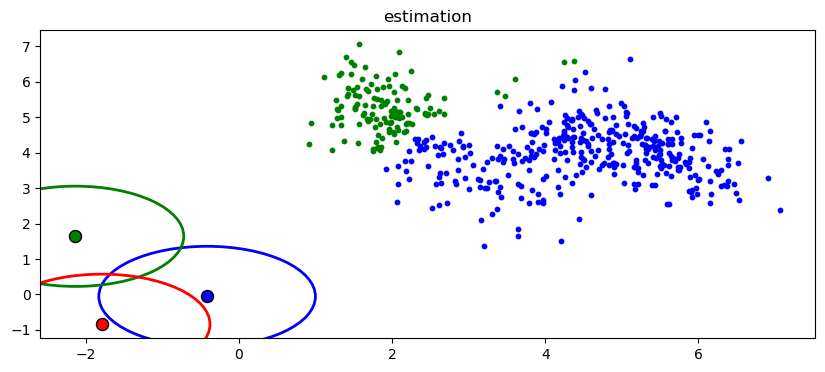

In [118]:
z_hat = np.argmax(resp, axis=1)

fig1 = plt.figure(figsize=(10,4))
ax1 = fig1.add_subplot(111)
plot_GMM(x, z_hat, gmm.means, gmm.covars, colors=['b','g','r'], ax=ax1)
ax1.set_title('estimation')

In [119]:
gmm.M_step(x, resp)

In [120]:
np.linalg.cholesky(gmm.covars)

array([[[ 1.20396904,  0.        ],
        [-0.03414387,  0.79187451]],

       [[ 0.76715066,  0.        ],
        [-0.09522541,  0.72556819]],

       [[ 0.87102775,  0.        ],
        [-0.27094415,  0.86878317]]])

In [121]:
LML = gmm.compute_LML(x)
delta_LML = LML - LML_init
print("log-marginal likelihood: %.4f" % LML)
print("log-marginal likelihood improvement: %.4f" % delta_LML)

if int(delta_LML*1000) == 19556:
    print("\nthe log-marginal likelihood increased, well done!")
else:
    print("argh, this is not the expected result, either you made a mistake, or my unit test is badly designed")

log-marginal likelihood: -2.9923
log-marginal likelihood improvement: 19.5563

the log-marginal likelihood increased, well done!


#### If you got all my encouraging messages, then you are ready to fit the GMM on the data!

In [122]:
LML = gmm.fit(data=x, n_iter=50)

In the following cell, we plot the log-marginal likelihood along the iterations. It should be monotonically increasing, a nice feature of the EM algorithm which is very useful for debugging: if the log-marginal likelihood decreases, there is a bug.

Text(0.5, 0, 'EM iterations')

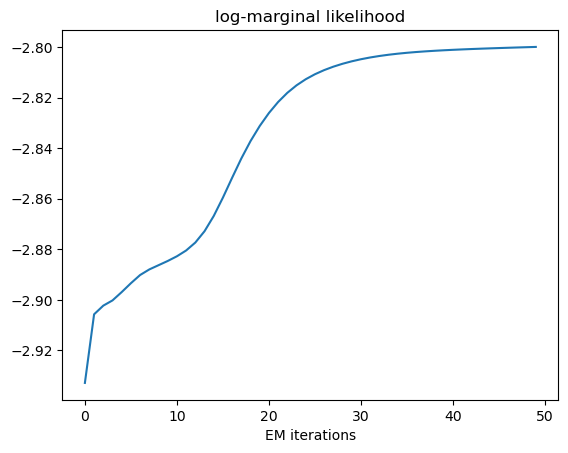

In [123]:
plt.plot(LML)
plt.title("log-marginal likelihood")
plt.xlabel("EM iterations")

Results

Text(0.5, 1.0, 'estimation')

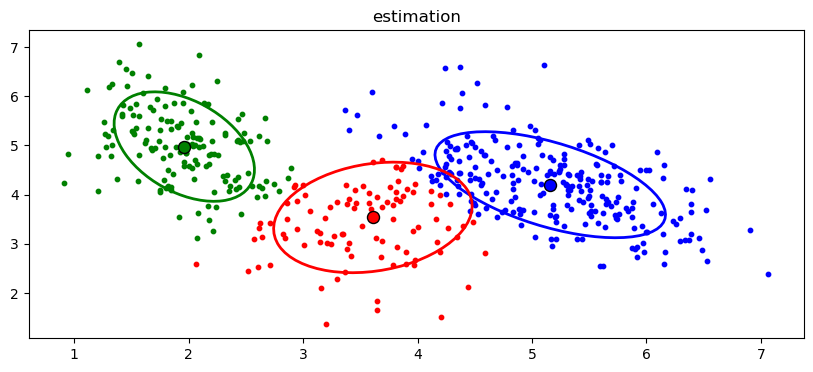

In [124]:
resp = gmm.E_step(x)
z_hat = np.argmax(resp, axis=1)

fig1 = plt.figure(figsize=(10,4))
ax1 = fig1.add_subplot(111)
plot_GMM(x, z_hat, gmm.means, gmm.covars, colors=['b','g','r'], ax=ax1)
ax1.set_title('estimation')

We used synthetic data, so we actually also know the true model parameters.

Text(0.5, 1.0, 'ground truth')

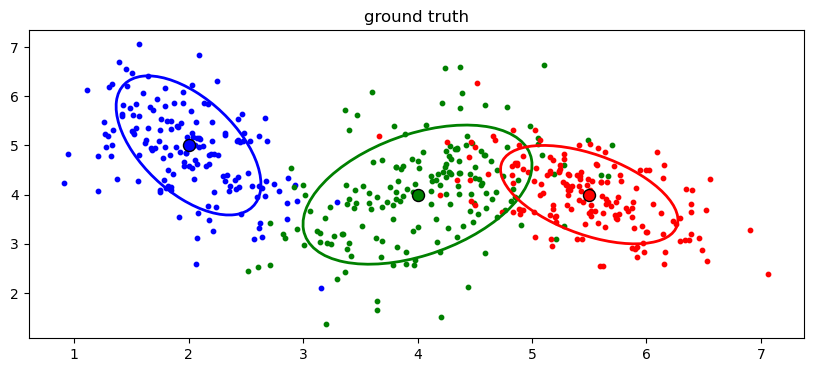

In [125]:
(pis_true, means_true, covars_true, z_true, _) = gen


fig2 = plt.figure(figsize=(10,4))
ax2 = fig2.add_subplot(111)
plot_GMM(x, z_true, means_true, covars_true, colors=['b','g','r'], ax=ax2)
ax2.set_title('ground truth')

This is not perfect, but not that bad either... 